In [504]:
import sys
sys.path.append("..")

import time
import pandas as pd
import matplotlib.pyplot as plt

from datasets.custom_dataset import CustomDataset

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Normalize

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

from sklearn.model_selection import train_test_split

# Carga del set de datos

## Directorios

In [505]:
dataset_path = '../datasets/dataset.csv'
images_path = '../datasets/dataset_images'

dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.sample(5).head()

,file_name,label
48825,Tomato_healthy_48825.jpg,21
32526,Corn_diseased_32526.jpg,15
16831,Strawberry_diseased_16831.jpg,9
22694,Tomato_diseased_22694.jpg,4
19422,Tomato_diseased_19422.jpg,4


## Distribución de las clases en el set de datos

In [506]:
class_ids = {
    0: 'no-leaf',
    1: 'squash-diseased',
    2: 'apple-healthy',
    3: 'orange-diseased',
    4: 'tomato-diseased',
    5: 'grape-diseased',
    6: 'blueberry-healthy',
    7: 'grape-healthy',
    8: 'pepper-healthy',
    9: 'strawberry-diseased',
    10: 'potato-healthy',
    11: 'raspberry-healthy',
    12: 'pepper-diseased',
    13: 'cherry-healthy',
    14: 'strawberry-healthy',
    15: 'corn-diseased',
    16: 'corn-healthy',
    17: 'potato-diseased',
    18: 'soybean-healthy',
    19: 'peach-healthy',
    20: 'apple-diseased',
    21: 'tomato-healthy',
    22: 'peach-diseased',
    23: 'cherry-diseased'
}

def count_dataset_classes(labels, class_ids):
    class_count = {}
    
    for label in labels:
        if(class_ids[label] not in class_count):
            class_count[class_ids[label]] = 1
        else:
            class_count[class_ids[label]] += 1
            
    return class_count

<Axes: title={'center': 'Distribución de clases en el dataset'}, xlabel='class'>

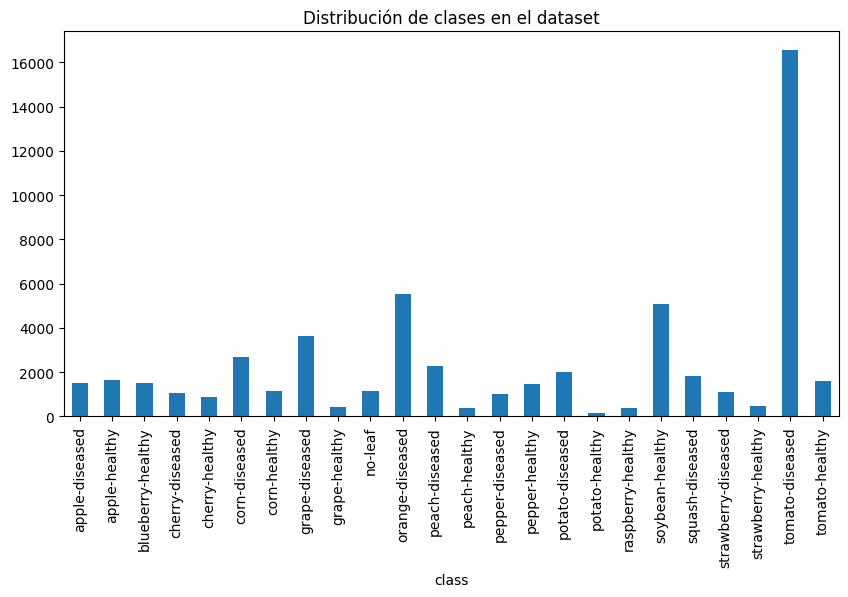

In [507]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)
dataset_class_count = {
    'class': list(dataset_class_count.keys()),
    'count': list(dataset_class_count.values())
}

df = pd.DataFrame.from_dict(dataset_class_count)
df.sort_values(by=['class'], inplace=True)
df.index = df['class']
df.plot(kind='bar', title='Distribución de clases en el dataset', legend=False, figsize=(10, 5))

## División del set de datos

### Set para la ejecución #1

In [508]:
X_encoder_1, X_classifier_1, y_encoder_1, y_classifier_1 = train_test_split(
    dataset_file_names, dataset_labels, train_size=0.8, random_state=420, stratify=dataset_labels)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_classifier_1, y_classifier_1, train_size=0.6, random_state=420, stratify=y_classifier_1)

print('Datos para el encoder', X_encoder_1.shape)
print('Datos para el clasificador:', X_classifier_1.shape)

print('\tDatos de entrenamiento para el clasificador:', X_train_1.shape)
print('\tDatos de prueba para el clasificador:', X_test_1.shape)

Datos para el encoder (44358,)
Datos para el clasificador: (11090,)
	Datos de entrenamiento para el clasificador: (6654,)
	Datos de prueba para el clasificador: (4436,)


### Set para la ejecución #2

In [509]:
X_encoder_2, X_classifier_2, y_encoder_2, y_classifier_2 = train_test_split(
    dataset_file_names, dataset_labels, train_size=0.5, random_state=204, stratify=dataset_labels)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_classifier_2, y_classifier_2, train_size=0.8, random_state=204, stratify=y_classifier_2)

print('Datos para el encoder', X_encoder_2.shape)
print('Datos para el clasificador:', X_classifier_2.shape)

print('\tDatos de entrenamiento para el clasificador:', X_train_2.shape)
print('\tDatos de prueba para el clasificador:', X_test_2.shape)

Datos para el encoder (27724,)
Datos para el clasificador: (27724,)
	Datos de entrenamiento para el clasificador: (22179,)
	Datos de prueba para el clasificador: (5545,)


## Feature Engineering

In [510]:
encoder_dataset_1 = CustomDataset(images_path, X_encoder_1, y_encoder_1, transform=Compose([
    Resize((250, 250)), # Se redimensionan las imágenes a 250x250 para que todas tengan las mismas dimensiones
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5) # Se normalizan los valores de los pixeles
]))

train_dataset_1 = CustomDataset(images_path, X_train_1, y_train_1, transform=Compose([
    Resize((250, 250)), 
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5) 
]))

test_dataset_1 = CustomDataset(images_path, X_test_1, y_test_1, transform=Compose([
    Resize((250, 250)),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

In [511]:
encoder_dataset_2 = CustomDataset(images_path, X_encoder_2, y_encoder_2, transform=Compose([
    Resize((250, 250)), # Se redimensionan las imágenes a 250x250 para que todas tengan las mismas dimensiones
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5) # Se normalizan los valores de los pixeles
]))

train_dataset_2 = CustomDataset(images_path, X_train_2, y_train_2, transform=Compose([
    Resize((250, 250)), # Se redimensionan las imágenes a 250x250 para que todas tengan las mismas dimensiones
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5) # Se normalizan los valores de los pixeles
]))

test_dataset_2 = CustomDataset(images_path, X_test_2, y_test_2, transform=Compose([
    Resize((250, 250)),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

# Uso de GPU si está disponible

In [512]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# Métricas de evaluación

## Definición de métricas

In [513]:
train_accuracy = MulticlassAccuracy(num_classes=24, average=None).to(device)
test_accuracy = MulticlassAccuracy(num_classes=24, average=None).to(device)

train_precision = MulticlassPrecision(num_classes=24, average=None).to(device)
test_precision = MulticlassPrecision(num_classes=24, average=None).to(device)

train_recall = MulticlassRecall(num_classes=24, average=None).to(device)
test_recall = MulticlassRecall(num_classes=24, average=None).to(device)

train_f1 = MulticlassF1Score(num_classes=24, average=None).to(device)
test_f1 = MulticlassF1Score(num_classes=24, average=None).to(device)

train_roc = MulticlassROC(num_classes=24).to(device)
test_roc = MulticlassROC(num_classes=24).to(device)

train_auroc = MulticlassAUROC(num_classes=24).to(device)
test_auroc = MulticlassAUROC(num_classes=24).to(device)

## Cálculo de métricas

In [514]:
def compute_metrics(train_list, test_list, train_loss, test_loss):
    train_list.append({
        'loss': train_loss,
        'accuracy': train_accuracy.compute(),
        'precision': train_precision.compute(), 
        'recall': train_recall.compute(),
        'f1': train_f1.compute(),
        'roc': train_roc.compute(),
        'auroc': train_auroc.compute()
    })
    
    test_list.append({
        'loss': test_loss,
        'accuracy': test_accuracy.compute(),
        'precision': test_precision.compute(),
        'recall': test_recall.compute(),
        'f1': test_f1.compute(),
        'roc': test_roc.compute(),
        'auroc': test_auroc.compute()
    })
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

## Tabla de métricas

In [515]:
def show_metrics_table(train_metrics, test_metrics, epochs):
    for epoch in range(epochs):
        print(f'------------------------------------------------------- Epoch #{epoch+1} -------------------------------------------------------')
        epoch_metrics_df = pd.DataFrame({
            'Class': list(class_ids.values()),
            
            'Train Accuracy': train_metrics[epoch]['accuracy'],
            'Test Accuracy': test_metrics[epoch]['accuracy'],
            
            'Train Precision': train_metrics[epoch]['precision'],
            'Test Precision': test_metrics[epoch]['precision'],
            
            'Train Recall': train_metrics[epoch]['recall'],
            'Test Recall': test_metrics[epoch]['recall'],
            
            'Train F1-Score': train_metrics[epoch]['f1'],
            'Test F1-Score': test_metrics[epoch]['f1']
        })
        display(epoch_metrics_df)

## Gráficas de entrenamiento

### Curva de entrenamiento

In [516]:
def show_learning_curve(train_losses, test_losses=None, epoch_list=[]):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss vs Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(epoch_list)

    ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
    if(test_losses is not None):
        ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

    ax.legend()
    fig.show()

### AUROC

In [517]:
def show_auroc_plot(train_roc_fpr, train_roc_tpr, train_auroc, test_roc_fpr, test_roc_tpr, test_auroc):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    for i in range(len(train_roc_tpr)):
        ax[0].plot(train_roc_fpr[i], train_roc_tpr[i], label=f'Class {i}')
        ax[1].plot(test_roc_fpr[i], test_roc_tpr[i], label=f'Class {i}')
    
    ax[0].set_title('Train ROC Curve - AUROC: {:.4f}'.format(train_auroc))
    ax[0].legend()
    
    ax[1].set_title('Test ROC Curve - AUROC: {:.4f}'.format(test_auroc))
    ax[1].legend()
    
    fig.show()

### Reconstrucción de imágenes

In [518]:
def reconstruct_image(model, dataloader, num_samples):
    model.eval()
    X_test = next(iter(dataloader))

    fig, ax = plt.subplots(2, num_samples, figsize=(12, 8))
    for i in range(num_samples):
        current_sample = X_test[0][i]
        reconstructed_image = model(current_sample)

        current_sample = current_sample.permute(1, 2, 0)
        current_sample = current_sample.detach().numpy()
        
        reconstructed_image = reconstructed_image.permute(1, 2, 0)
        reconstructed_image = reconstructed_image.detach().numpy()
        
        ax[0, i].imshow(current_sample)
        ax[0, i].axis('off')

        ax[1, i].imshow(reconstructed_image)
        ax[1, i].axis('off')

    plt.show()

# Función de entrenamiento

In [519]:
def train(dataloader, model, loss_fn, optimizer, unsupervised=False):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    loss = torch.Tensor([0]).to(device)
    epoch_loss = 0
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
    
        if(unsupervised):
            loss = loss_fn(pred, X)
        else:
            train_accuracy.update(pred, y)
            train_precision.update(pred, y)
            train_recall.update(pred, y)
            train_f1.update(pred, y)    
            train_roc.update(pred, y)
            train_auroc.update(pred, y)
            
            loss = loss_fn(pred, y)
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item()/(batch+1), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return epoch_loss / num_batches

# Función de evaluación

In [520]:
def test(dataloader, model, loss_fn, update_metrics=True):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            if(update_metrics):
                test_accuracy.update(pred, y)
                test_precision.update(pred, y)
                test_recall.update(pred, y)
                test_f1.update(pred, y)    
                test_roc.update(pred, y)
                test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    current_metrics_df = pd.DataFrame({
        'Class': list(class_ids.values()),
        'Test Accuracy': test_accuracy.compute(),
        'Test Precision': test_precision.compute(),
        'Test Recall': test_recall.compute(),
        'Test F1-Score': test_f1.compute()
    })
    current_metrics_df.style.set_caption('Current Test Metrics')
    display(current_metrics_df)
    return test_loss

# Arquitectura del Autoencoder

In [521]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.encoder_conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3)
        self.encoder_conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3)
        self.encoder_conv4 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        
        self.decoder_t_conv1 = nn.ConvTranspose2d(in_channels=1, out_channels=4, kernel_size=3)
        self.decoder_t_conv2 = nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=3)
        self.decoder_t_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3)
        self.decoder_t_conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3)


    def encode(self, x, return_indices=False):
        x = F.relu(self.encoder_conv1(x))
        x, pool_indices_1 = self.pool(x)
        
        x = F.relu(self.encoder_conv2(x))
        x, pool_indices_2 = self.pool(x)
        
        x = F.relu(self.encoder_conv3(x))
        x, pool_indices_3 = self.pool(x)
        
        x = self.encoder_conv4(x)
        
        if(return_indices == True):
            return x, [pool_indices_1, pool_indices_2, pool_indices_3]
        else:
            return x
    
    
    def decode(self, x, pool_indices):
        x = F.relu(self.decoder_t_conv1(x))
        x = self.unpool(x, pool_indices[2], output_size=(59, 59))
        
        x = F.relu(self.decoder_t_conv2(x))
        x = self.unpool(x, pool_indices[1], output_size=(122, 122))
        
        x = F.relu(self.decoder_t_conv3(x))
        x = self.unpool(x, pool_indices[0], output_size=(248, 248))
        
        x = F.sigmoid(self.decoder_t_conv4(x))
        
        return x
        
        
    def forward(self, x):
        encoded_x, pool_indices = self.encode(x, return_indices=True)
        decoded_x = self.decode(encoded_x, pool_indices)
        return decoded_x

# Arquitectura del Clasificador

In [522]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=61504, out_features=24),
            nn.ReLU()
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

# Parámetros de entrenamiento

In [523]:
batch_size = 32
learning_rate = 1e-3
momentum = 0.2
epochs = 2

# Partición #1

## Entrenamiento del Autoencoder

In [524]:
autoencoder_model_1 = Autoencoder().to(device)

autoencoder_loss_fn_1 = nn.MSELoss()
autoencoder_optimizer_1 = torch.optim.SGD(autoencoder_model_1.parameters(), lr=learning_rate, momentum=momentum)

autoencoder_dataloader_1 = DataLoader(
    encoder_dataset_1, batch_size=batch_size, shuffle=True)

### Ciclo de entrenamiento

In [525]:
train_loss = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    epoch_loss = train(autoencoder_dataloader_1, autoencoder_model_1, autoencoder_loss_fn_1, autoencoder_optimizer_1, unsupervised=True)
    train_loss.append(epoch_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------



/home/rijegaro/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Current Loss: 0.483560  [   32/44358]


Current Loss: 0.043868  [  352/44358]
Current Loss: 0.025057  [  672/44358]
Current Loss: 0.018380  [  992/44358]
Current Loss: 0.012216  [ 1312/44358]
Current Loss: 0.010377  [ 1632/44358]
Current Loss: 0.009187  [ 1952/44358]
Current Loss: 0.007305  [ 2272/44358]
Current Loss: 0.006956  [ 2592/44358]
Current Loss: 0.005822  [ 2912/44358]
Current Loss: 0.004684  [ 3232/44358]
Current Loss: 0.004235  [ 3552/44358]
Current Loss: 0.003819  [ 3872/44358]
Current Loss: 0.004140  [ 4192/44358]
Current Loss: 0.003384  [ 4512/44358]
Current Loss: 0.003151  [ 4832/44358]
Current Loss: 0.003404  [ 5152/44358]
Current Loss: 0.002991  [ 5472/44358]
Current Loss: 0.002969  [ 5792/44358]
Current Loss: 0.002537  [ 6112/44358]
Current Loss: 0.002503  [ 6432/44358]
Current Loss: 0.002427  [ 6752/44358]
Current Loss: 0.002374  [ 7072/44358]
Current Loss: 0.002009  [ 7392/44358]
Current Loss: 0.001967  [ 7712/44358]
Current Loss: 0.002054  [ 8032/44358]
Current Loss: 0.002034  [ 8352/44358]
Current Loss

KeyboardInterrupt: 

### Evaluación del modelo

#### Curva de entrenamiento

/tmp/ipykernel_4085/136305795.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


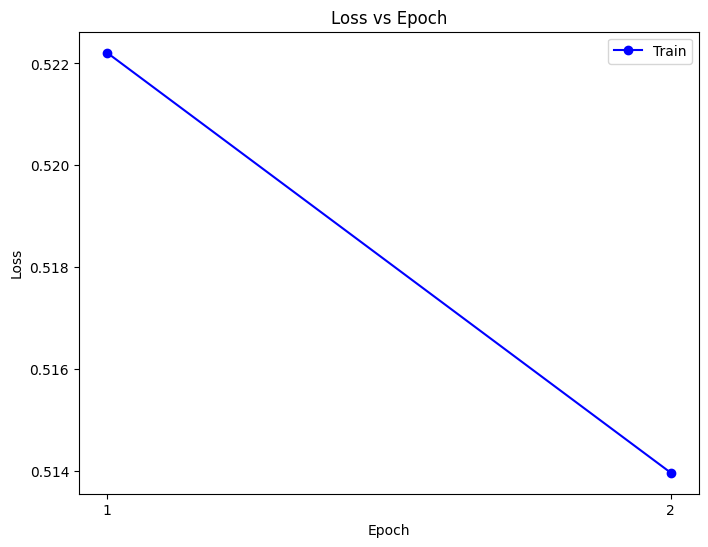

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
show_learning_curve(train_loss, epoch_list=epoch_list)

#### Reconstrucción de imágenes

/home/rijegaro/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.48755467 0.520285   0.52538025]
  [0.47686172 0.50934887 0.52611434]
  [0.4879936  0.5278408  0.52045786]
  ...
  [0.48234418 0.51787406 0.52421016]
  [0.4802403  0.51535046 0.5185946 ]
  [0.48527247 0.5173764  0.5206674 ]]

 [[0.48346484 0.509244   0.51351815]
  [0.47663748 0.5079649  0.5207632 ]
  [0.4850904  0.51276654 0.5088904 ]
  ...
  [0.4837987  0.5101288  0.5186015 ]
  [0.4728284  0.5044067  0.51485395]
  [0.4828779  0.5084328  0.51778066]]

 [[0.4884205  0.5052216  0.52043164]
  [0.4919438  0.514302   0.5196109 ]
  [0.48084995 0.511951   0.52305084]
  ...
  [0.48245937 0.5175267  0.529361  ]
  [0.4803085  0.5100302  0.5174142 ]
  [0.475689   0.5154604  0.51983315]]

 ...

 [[0.47986993 0.5011943  0.5153004 ]
  [0.47881293 0.51147527 0.517359  ]
  [0.4732279  0.5076581  0.5164349 ]
  ...
  [0.48902816 0.50678366 0.5170621 ]
  [0.47235015 0.51440793 0.5155194 ]
  [0.4882615  0.50973785 0.520714  ]]

 [[0.48753005 0.50296706 0.51754415]
  [0.48816523 0.5059344  0.51806444]


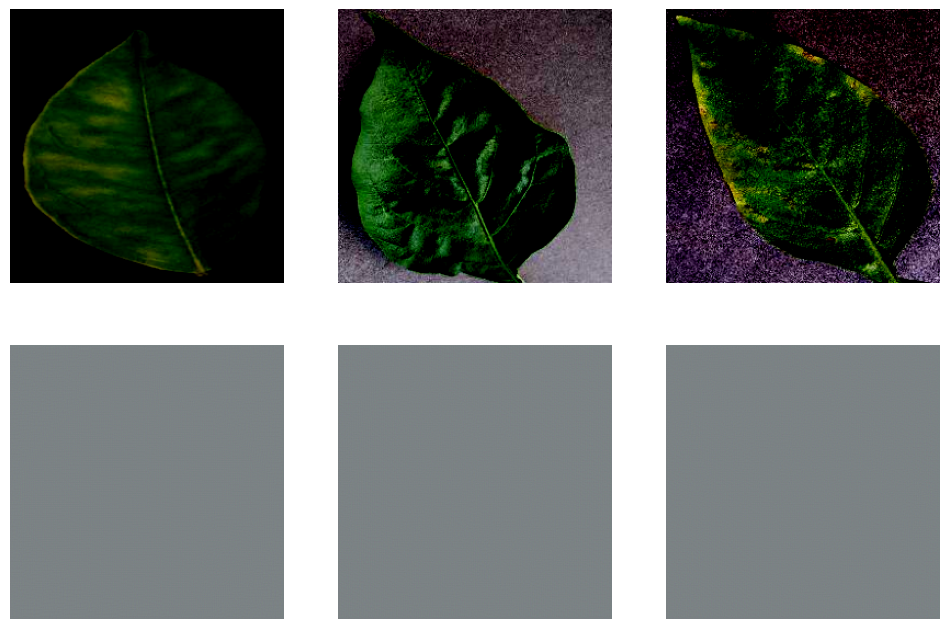

In [ ]:
test_dataloader_1 = DataLoader(
    test_dataset_1, batch_size=batch_size, shuffle=True)
    
reconstruct_image(autoencoder_model_1, test_dataloader_1, num_samples=3)

## Entrenamiento del Clasificador sin Autoencoder

In [ ]:
classifier_model_1 = Classifier().to(device)

classifier_loss_fn_1 = nn.CrossEntropyLoss()
classifier_optimizer_1 = torch.optim.SGD(classifier_model_1.parameters(), lr=learning_rate, momentum=momentum)

classifier_train_dataloader_1 = DataLoader(
    train_dataset_1, batch_size=batch_size, shuffle=True)

classifier_test_dataloader_1 = DataLoader(
    test_dataset_1, batch_size=batch_size, shuffle=True)

### Ciclo de entrenamiento

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    epoch_loss = train(classifier_train_dataloader_1, classifier_model_1, classifier_loss_fn_1, classifier_optimizer_1)
    test_loss = test(test_dataloader_1, classifier_model_1, classifier_loss_fn_1)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

### Evaluación del modelo

#### Curva de entrenamiento

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

#### Métricas

In [ ]:
show_metrics_table(train_metrics, test_metrics, epochs)

#### AUROC

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]
train_auroc = train_metrics[-1]['auroc'].item()

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]
test_auroc = test_metrics[-1]['auroc'].item()

show_auroc_plot(train_roc_fpr, train_roc_tpr, train_auroc, test_roc_fpr, test_roc_tpr, test_auroc)